# Sehgal Radio Sources

Implementing new models like radio sources in the `xgpaint.jl` framework is trivial (I hope). Actually, it'll be really interesting to see what parts of are shared between CIB and radio. This will inform the architecture of the final code package.

# 1. Read a Catalog

We operate with HDF5. I convert the `.pksc` format into `.hdf5` in the `pksc2hdf5.py` script (needs some work).

In [1]:
using PyPlot
PyPlot.svg(true);

In [2]:
const NPROCS = 40

using Distributed
addprocs(NPROCS);

In [3]:
@everywhere begin
    using HDF5
    using SharedArrays
    using Healpix
    using PoissonRandom
    using Distributions
    using Interpolations
    using QuadGK
    using Base.GC
    using Roots
    using Cosmology
    using Unitful
    using UnitfulAstro
    
    using Random
    # set different seeds for worker IDs
    Random.seed!(myid() + trunc(Int64, time()))
end

The radio sources do not have "centrals" or "satellites". They just live in the halos. Hence, we are storing instead `halo_n_I` and `halo_n_II`, the halo occupation numbers.

In [ ]:
@time begin
    hdata = h5open("/tigress/zequnl/xgpaint/websky_halos-light.hdf5", "r") do file
        read(file, "halos")
    end
    
    N_halos = size(hdata,2)
    
    halo_x_pos = SharedArray{Float32}(N_halos)
    halo_y_pos = SharedArray{Float32}(N_halos)
    halo_z_pos = SharedArray{Float32}(N_halos)
    halo_mass = SharedArray{Float32}(N_halos)
    
    # fill up known quantities
    halo_x_pos .= hdata[1,:]
    halo_y_pos .= hdata[2,:]
    halo_z_pos .= hdata[3,:]
    halo_mass .= hdata[4,:]
    hdata = 0
    @everywhere GC.gc()
    
    # derived parameters
    halo_comoving_dist = SharedArray{Float32}(N_halos)
    halo_redshift = SharedArray{Float32}(N_halos)
    
    halo_n_I = SharedArray{Int32}(N_halos)
    halo_n_II = SharedArray{Int32}(N_halos)
end;

We specify the parameters here. We're taking the model parameters straight from Table 2 of Sehgal et al. 2009.

![pasted image](data/table.png)

In [ ]:
@everywhere begin
    # sehgal model parameters
    
    # these coefficients are shared for type I and II
    const a_0   = 0.0
    const a_1_dist = Uniform(-0.12,  0.07)
    const a_2_dist = Uniform(-0.34,  0.99)
    const a_3_dist = Uniform(-0.75, -0.23)
    
    const I_R_int = 10^(-2.6)
    const I_gamma = 6.0
    const I_N_0 = 1.0
    const I_M_0 = 4e13
    const I_alpha = 0.1
    const I_L_b = 10^(24.0)
    const I_m = -1.55
    const I_n = 0.0
    const I_delta = 3.0
    const I_z_p = 0.8
    
    const II_R_int = 10^(-2.8)
    const II_gamma = 8.0
    const II_N_0 = 0.015
    const II_M_0 = 3e15
    const II_alpha = 0.1
    const II_L_b = 10^(27.5)
    const II_m = -1.6
    const II_n = -0.65
    const II_z_p = 1.3
    const II_sigma_l = 0.4
    const II_sigma_h = 0.73
    
    
    # output
    const nside   = 4096
    
    # physical constants
    const phys_h     = 6.62606957e-27   # erg.s
    const phys_c     = 3e+10            # cm/s
    const phys_k     = 1.3806488e-16    # erg/K
    const phys_Msun  = 2e33             # g
    const phys_Mpc   = 3.086e24         # cm
    
    # cosmology
    const omegab  = 0.043
    const omegac  = 0.207
    const omegam  = omegab + omegac
    const h = 0.7
    const rhocrit = 2.78e11 * omegam * (h^2)
    
    const jl_cosmo = cosmology(h=h, OmegaM=omegam)
end

In [ ]:
@everywhere function build_r2z_interpolator()
    """
    Construct a fast r2z linear interpolator.
    """
    zrange = LinRange(0.0, 6.0, 1000)
    rrange = [ustrip(comoving_radial_dist(u"Mpc", jl_cosmo, z))
        for z in zrange];
    r2z = LinearInterpolation(rrange, zrange);
    return r2z
end

@everywhere const r2z = build_r2z_interpolator()

In [ ]:
function fill_halovars!(
        x, y, z, # inputs
        redshift_result, dist_result) # outputs
    """
    This function computes distance and redshift in parallel.
    """
    
    N_halos = size(x,1)
    @sync @distributed for i = 1:N_halos
        dist_result[i] = sqrt(x[i]^2 + y[i]^2 + z[i]^2)
        redshift_result[i] = r2z(dist_result[i])
    end
end

We compute the comoving distance, spherical coordinates, and redshift of the halos and store them in the shared memory array `halo_derived`. It's in parallel, so it takes just seconds!

In [ ]:
@time fill_halovars!(halo_x_pos, halo_y_pos, halo_z_pos,
    halo_redshift, halo_comoving_dist)

In [ ]:
@everywhere GC.gc()

# 2. HOD
We assign a number of satellites to each halo. Sehgal assumes the halo occupation number (HON) is given by
$$ N(M) = N_0 (M / M_0)^{\alpha}.$$

In [ ]:
function hod_sehgal(n_I_result, n_II_result,  halo_mass::SharedArray)
    # computes sehgal HOD and generates a Poisson draw
    N_halos = size(halo_mass,1)
    
    @sync @distributed for i = 1:N_halos
        I_HON = I_N_0 * (halo_mass[i] / I_M_0)^I_alpha
        n_I_result[i] = pois_rand(convert(Float64, I_HON))
        II_HON = I_N_0 * (halo_mass[i] / II_M_0)^II_alpha
        n_II_result[i] = pois_rand(convert(Float64, II_HON))
    end
    
end

In [ ]:
@time hod_sehgal(halo_n_I, halo_n_II, halo_mass)

# 3. Halos to Sources to Maps

This is a loop *for each halo*, which does the following.

```
for loop over $n_{halo}$
    for loop over $n_{sat}$ of the halo
        do tasks
```

### Tasks
1. draw a random source
2. assign it a luminosity 
3. convert that luminosity to a flux
4. map to a healpix pixel index and add that flux

The Sehgal LF is

$$ p(L) = \begin{cases}   (L/L_b)^m &  L > L_b \\  (L/L_b)^n & \mathrm{otherwise} \end{cases} $$

In [ ]:
@everywhere begin
    function sehgal_LF(m, n, Lb)
        p0 = (1+m) * (1+n) / Lb / (m-n)
        Fb = Lb * p0 / (1+n)
        x = rand()
        if x < Fb
            return (Lb^n * (1.0+n) * x / p0)^(1 / (1+n))
        else
            return (-Lb^m * (1+m) * (Lb * p0 * ( 1/(1+n) - 1/(1+m) ) - x) / p0 )^(1 / (1+m))
        end
    end
end

In [ ]:
I_draws = [ sehgal_LF(I_m, I_n, I_L_b) for i in 1:1000000 ]
hist( I_draws, bins=10 .^ LinRange(15,35,100), 
    histtype="step", density=true, label="FR I" )

II_draws = [ sehgal_LF(II_m, II_n, II_L_b) for i in 1:1000000 ]
hist( II_draws, bins=10 .^ LinRange(15,35,100), 
    histtype="step", density=true, label="FR II" )

xscale("log")
yscale("log")
xlabel("L [W/Hz]")

# Lobe/Core and Spectral Shape

In [15]:
@everywhere const Healpix_res = Resolution(nside)

In [16]:
@everywhere function l2f(Lum, r_comoving, redshift)
    return Lum / (4pi * r_comoving^2 * (1.0 + redshift))
end

In [17]:
source_L_I = SharedArray{Float32}(sum(halo_n_I))
source_z_I = SharedArray{Float32}(sum(halo_n_I))
source_L_II = SharedArray{Float32}(sum(halo_n_II))
source_z_II = SharedArray{Float32}(sum(halo_n_II));

In [18]:
function make_map(x, y, z, d_cm, redshift, 
        n_I, n_II, nu_obs, 
        
        L_I, z_I, L_II, z_II, debug=false
    )
    """Generate a CIB map given a HOD."""
    N_halos = size(d_cm,1)

    result_map = SharedArray{Float64}(Healpix.nside2npix(nside)); 
    result_map .= 0.0 # initialize to zero
    
    
    if debug
        println("debug mode! creating source indices.")
        source_I_ind = SharedArray{Int32}(N_halos)
        source_II_ind = SharedArray{Int32}(N_halos)
        counter_I = 0
        counter_II = 0
        for i in 1:N_halos
            source_I_ind[i] = counter_I
            source_II_ind[i] = counter_II
            counter_I += n_I[i]
            counter_II += n_II[i]
        end
    end
    
    
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
        nu  = (1+redshift[i]) * nu_obs
        hp_index = Healpix.vec2pixRing(Healpix_res, x[i], y[i], z[i])
        
        # do it for FR_I
        for j = 1:n_I[i]
            lum = sehgal_LF(I_m, I_n, I_L_b)
            flux = l2f(lum, d_cm[i], redshift[i])
            result_map[hp_index] += flux
            
            if debug
                L_I[source_I_ind[i] + j] = lum
                z_I[source_I_ind[i] + j] = redshift[i]
            end
        end
        
        # do it for FR_II
        for j = 1:n_II[i]
            lum = sehgal_LF(II_m, II_n, II_L_b)
            flux = l2f(lum, d_cm[i], redshift[i])
            result_map[hp_index] += flux
            
            if debug
                L_II[source_II_ind[i] + j] = lum
                z_II[source_II_ind[i] + j] = redshift[i]
            end
        end
        
    end
    return result_map
end

make_map (generic function with 2 methods)

In [19]:
@time result = make_map(
    halo_x_pos, halo_y_pos, halo_z_pos, 
    halo_comoving_dist, halo_redshift,
    halo_n_I, halo_n_II, 100e9,
    
    source_L_I, source_z_I, source_L_II, source_z_II, true
);

debug mode! creating source indices.
 63.581978 seconds (3.45 G allocations: 51.519 GiB, 4.20% gc time)


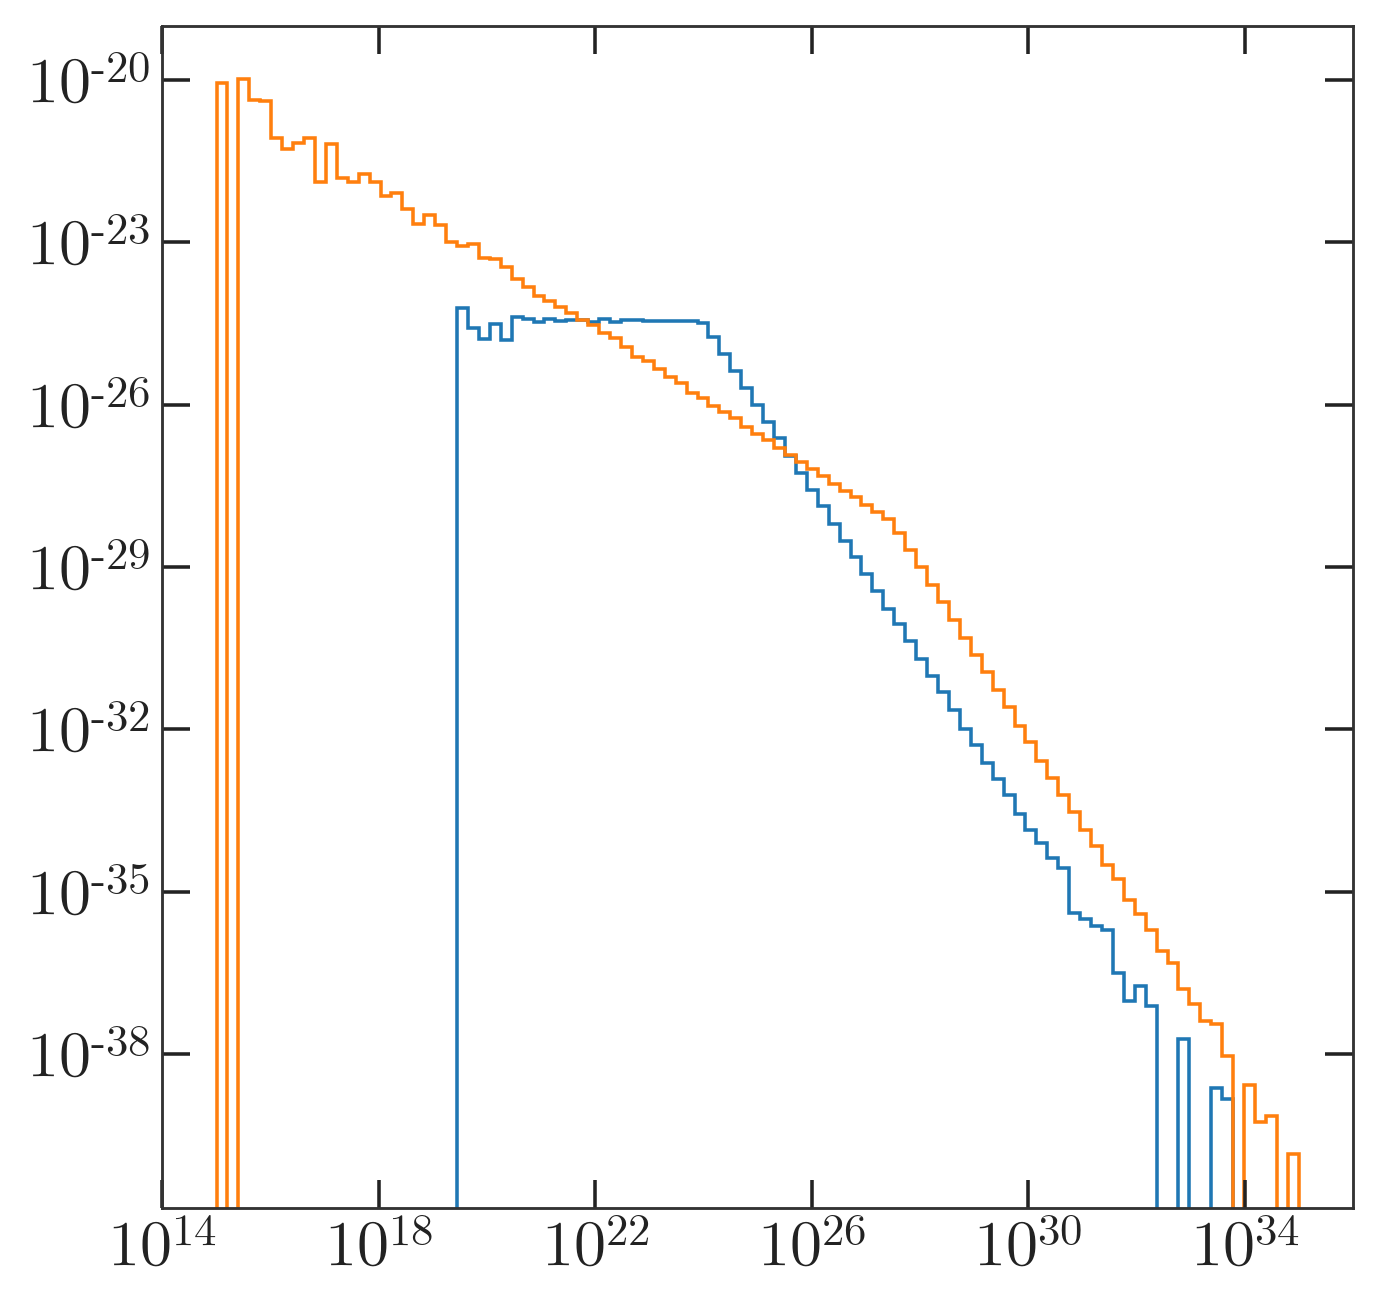

In [20]:
valsI, binsI = hist( source_L_I[source_z_I .< 0.1], bins=10 .^ LinRange(15,35,100), 
    histtype="step", density=true, label="FR I" )
valsII, binsII = hist( source_L_II[source_z_II .< 0.1], bins=10 .^ LinRange(15,35,100), 
    histtype="step", density=true, label="FR II" )
yscale("log")
xscale("log")

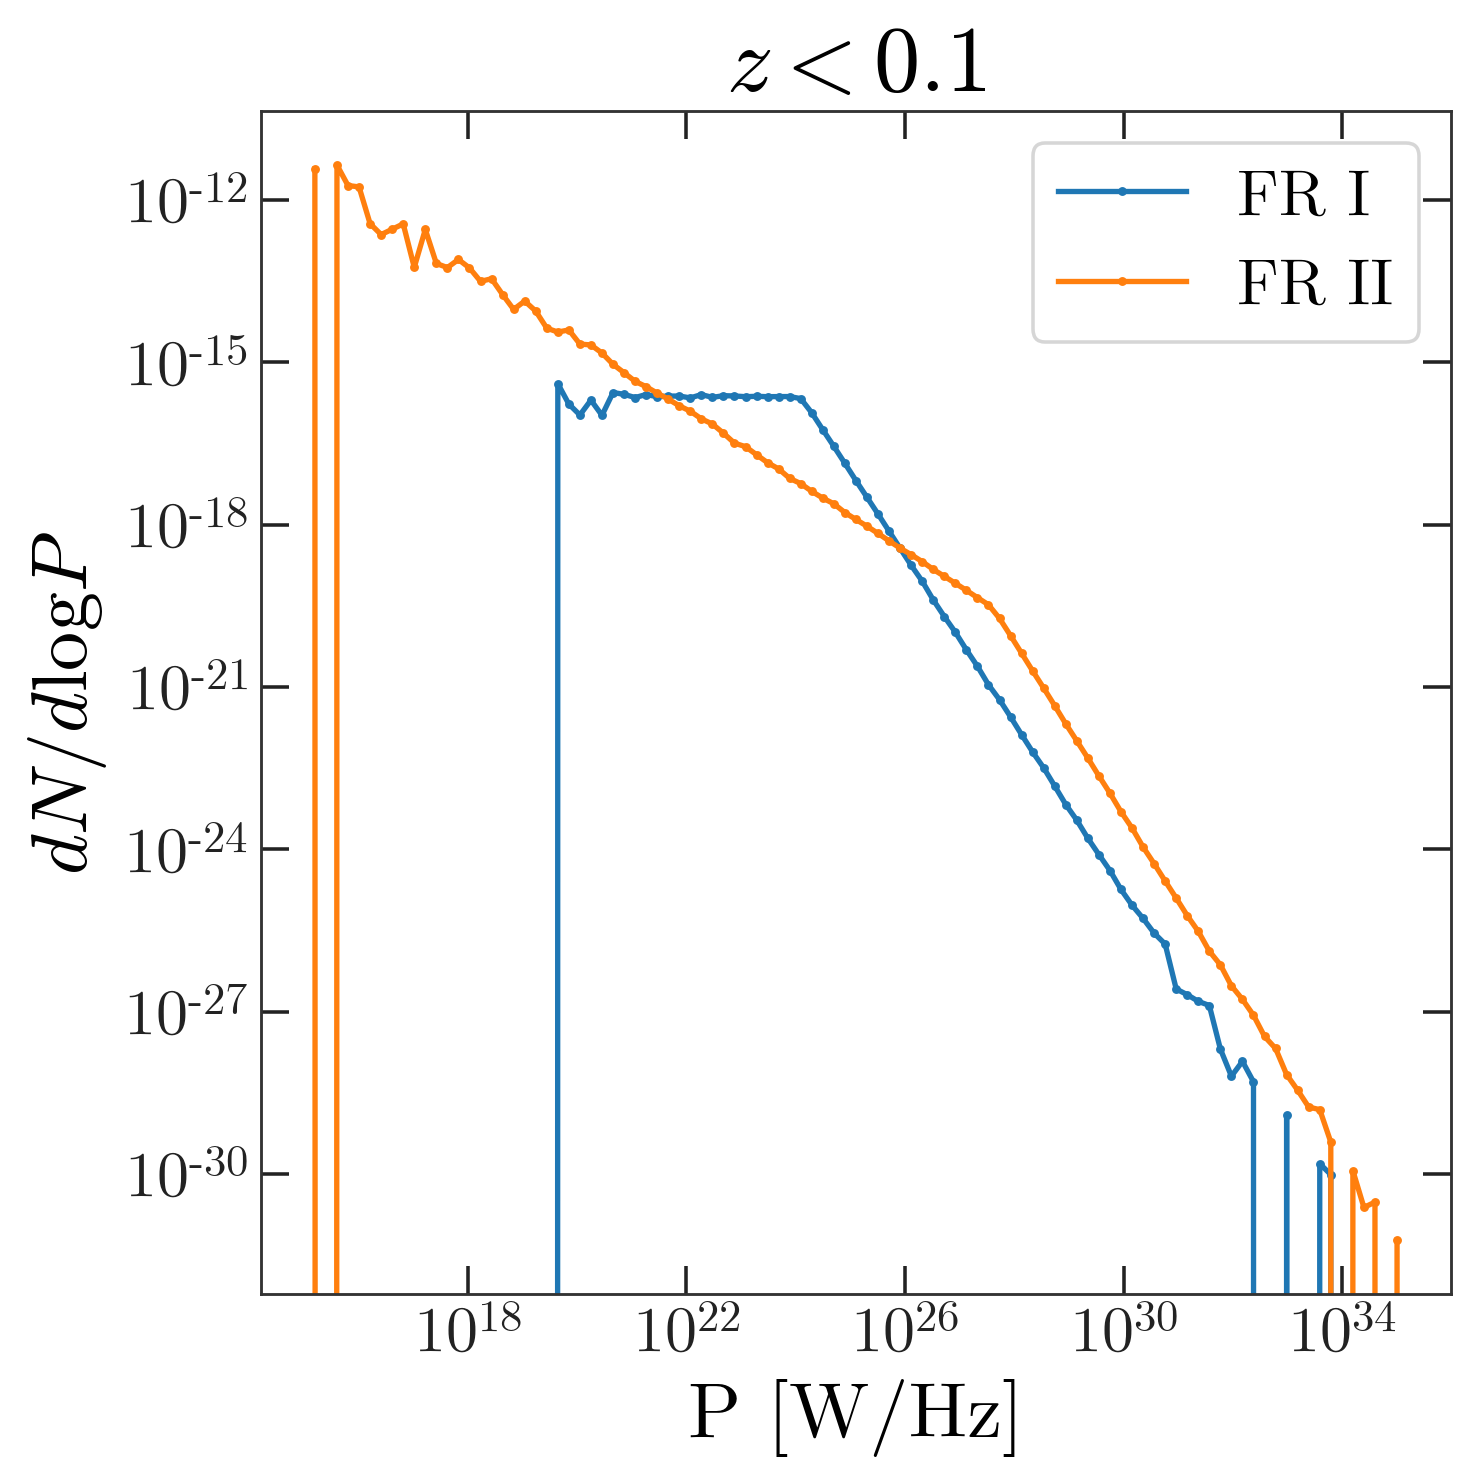

PyObject <matplotlib.legend.Legend object at 0x2b36e971d400>

In [31]:
plot(binsI[2:end], valsI * sum(halo_n_I), label="FR I")
plot(binsII[2:end], valsII * sum(halo_n_II), label="FR II")
xscale("log")
yscale("log")

title("\$ z < 0.1 \$")
ylabel("\$ dN/d \\log P \$")
xlabel("P [W/Hz]")
legend()

In [22]:
# @time result = make_map(
#     halo_x_pos, halo_y_pos, halo_z_pos, 
#     halo_comoving_dist, halo_redshift,
#     halo_n_I, halo_n_II, 100e9
# );

In [23]:
# using Plots
# gr()  # Use the GR backend

# logm = Map{Float64, RingOrder}(nside)
# logm.pixels .= log10.(result);
# Plots.plot( logm )

In [24]:
# run(`rm /tigress/zequnl/xgpaint/cib100.fits`)

In [25]:
# m = Map{Float64, RingOrder}(nside)
# m.pixels .= result;
# Healpix.saveToFITS(m, "/tigress/zequnl/xgpaint/cib100.fits")